# Posterior Estimation of SBML Models

_Author: Jonas Arruda_

[SBML](https://sbml.org) is a free and open data format for describing models in computational systems biology. This notebook illustrates how the SBML format can be used together the simulation toolboxes [RoadRunner](https://libroadrunner.readthedocs.io/en/latest/index.html): "The Roadrunner Simulation Engine is a C++ library for simulating and analysing systems of differential equations. Roadrunner was designed with performance as a priority and is an exceptionally fast simulator." However, there are many different simulators out there, which might be more suitable for the defined model, such as [AMICI](https://amici.readthedocs.io/en/latest/), which can also be easily used in a similar way.

To follow this notebook, you need to have (at least) BayesFlow (with any backend) and RoadRunner installed.

In [1]:
from tests.test_datasets.conftest import workers
# install if not done yet
!pip install libroadrunner --quiet

In [2]:
import os

import numpy as np
import roadrunner

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import keras

# For BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

## Import an SBML Model to BayesFlow


First, we read the SBML model, create a roadrunner model and then import it in BayesFlow. You can either read a local file or use a model from the BioModels database: a repository of mathematical models of biological and biomedical systems. Roadrunner can handle stochastic or deterministic models. Here, as an example, we use the model [Cell-to-cell variability in JAK2/STAT5 pathway](https://www.ebi.ac.uk/biomodels/BIOMD0000001077#Overview) from Adlung et al. (2021).


In [3]:
# read the sbml model

# you can either read a local file
# sbml_file = 'example_model.xml'

# or download it from BioModels: a repository of mathematical models of biological and biomedical systems
sbml_model_url = (
    "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001077?filename=Adlung2021%20_model_jakstat_pa.xml"
)

# sometimes roadrunner has problems with the ssl certificate, you can ignore it by
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

rr = roadrunner.RoadRunner(sbml_model_url)

In [4]:
# switching between an ODE simulation and a stochastic simulation is as easy as
# rr.setIntegrator('gillespie')

Now that we have the model, we need to specify which states of the model are observed and which parameters we want to estimate.

In [5]:
observed_species = ["Total_STAT5", "measuralbe_pSTAT5"]
param_names = ["init_EpoRJAK2", "init_SHP1", "init_STAT5"]
# all other parameters are fixed to their default values defined in the SBML model

In [6]:
sim = rr.simulate(0, 300, 100, selections=["time"] + observed_species)
rr.reset()

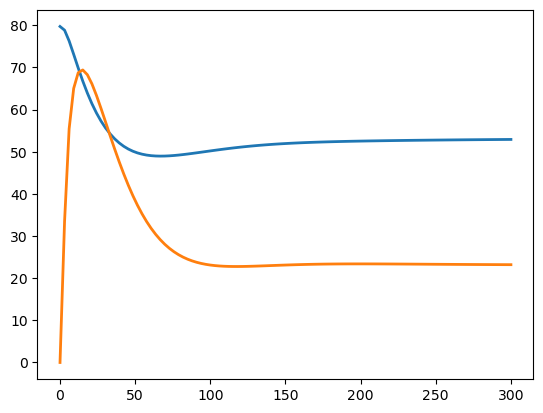

In [7]:
rr.plot()

## Define the Generative Model

We can now define the generative model for BayesFlow. The generative model is a combination of a simulator and a prior. The simulator takes parameter values from the prior and returns simulated data. The generative model is used to generate synthetic data for training the amortized posterior. Since we are using a deterministic simulator in this example, we need to define a noise model for the observations. Here, we assume additive independent normal noise on the observations. The noise parameters are added to the parameter vector and are estimated by BayesFlow.

In [8]:
def sbml_simulator(init_EpoRJAK2, init_SHP1, init_STAT5, sigma_Total_STAT5, sigma_measuralbe_pSTAT5,
                   simulation_duration, eval_points):

    # set the observed species
    rr.timeCourseSelections = observed_species

     # we have to reset the model to the original state
    rr.reset()
    # give roadrunner the current parameters and simulate
    rr['init_EpoRJAK2'] = init_EpoRJAK2
    rr['init_SHP1'] = init_SHP1
    rr['init_STAT5'] = init_STAT5
    # simulate the model with the current parameters
    out = rr.simulate(0, simulation_duration, eval_points)
    # add noise on observations (assuming additive independent normal noise here)
    out += np.random.multivariate_normal(
        mean=np.zeros(len(observed_species)), cov=np.diag(np.array([sigma_Total_STAT5, sigma_measuralbe_pSTAT5])),
        size=eval_points
    )
    return dict(Total_STAT5=out[:, 0], measuralbe_pSTAT5=out[:, 1])

In [9]:
def meta(batch_size):
    # this can either be set once, or vary per simulation batch
    # this depends on how different the datasets you want to analyze are going to be
    return dict(eval_points=np.random.randint(5, 150), simulation_duration=300)

We now have to define our prior, which is not encoded in the SBML model. For every parameter, which we like to estimate, we define a prior distribution. All other parameters will be fixed to their default values defined in the SBML model.

In [10]:
# build the prior
def param_prior():
    prior_dict = {
        "init_EpoRJAK2": np.random.uniform(0, 10),
        "init_SHP1": np.random.uniform(0, 10),
        "init_STAT5": np.random.uniform(0, 10),
        'sigma_Total_STAT5': np.random.uniform(0, 10),
        'sigma_measuralbe_pSTAT5': np.random.uniform(0, 10),
    }
    return prior_dict

In [11]:
prior = param_prior()
prior

{'init_EpoRJAK2': 7.885555381726574,
 'init_SHP1': 3.7467253543973698,
 'init_STAT5': 7.058360501995774,
 'sigma_Total_STAT5': 6.77796686511778,
 'sigma_measuralbe_pSTAT5': 6.828977468457216}

In [12]:
simulator = bf.make_simulator([param_prior, sbml_simulator], meta_fn=meta)

{'eval_points': 115,
 'simulation_duration': 300,
 'init_EpoRJAK2': array([[3.54129113],
        [8.06371631]]),
 'init_SHP1': array([[1.28344114],
        [1.82291542]]),
 'init_STAT5': array([[6.88892335],
        [8.07712055]]),
 'sigma_Total_STAT5': array([[4.55860614],
        [5.88890745]]),
 'sigma_measuralbe_pSTAT5': array([[7.19254617],
        [4.86660302]]),
 'Total_STAT5': array([[78.02342631, 80.4978191 , 74.99098872, 70.73175326, 72.10270912,
         71.05950638, 65.04599777, 65.00048761, 61.31020932, 59.41142774,
         55.71614987, 58.80093606, 54.09195217, 60.59686295, 53.11918467,
         51.96080646, 47.95091601, 52.98085075, 47.84290586, 49.16674815,
         50.36560517, 50.48430692, 52.25803136, 48.59821877, 47.31340636,
         53.32111304, 49.60757798, 48.06696969, 49.674248  , 51.65904438,
         51.09075278, 47.12551347, 47.75070445, 53.51315445, 48.68174301,
         50.45302726, 48.12475088, 52.00562954, 48.97467319, 47.83254667,
         50.04322536,

In [13]:
adapter = bf.approximators.ContinuousApproximator.build_adapter(
    inference_variables=prior.keys(),
    summary_variables=observed_species
)
adapter

Adapter([ToArray -> ConvertDType -> Concatenate(['init_EpoRJAK2', 'init_SHP1', 'init_STAT5', 'sigma_Total_STAT5', 'sigma_measuralbe_pSTAT5'] -> 'inference_variables') -> AsSet -> Concatenate(['Total_STAT5', 'measuralbe_pSTAT5'] -> 'summary_variables') -> Keep(['inference_variables', 'inference_conditions', 'summary_variables']) -> Standardize])

## Train BayesFlow

Now we can define the neural networks and train BayesFlow on simulated data.

In [14]:
summary_net = bf.networks.TimeSeriesTransformer(summary_dim=len(prior)*2)

In [15]:
inference_net = bf.networks.FlowMatching()

In [16]:
approximator = bf.approximators.ContinuousApproximator(
    summary_network=summary_net,
    inference_network=inference_net,
    adapter=adapter
)

In [17]:
learning_rate = 1e-4
optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=1.0)

In [18]:
approximator.compile(optimizer=optimizer)

In [21]:
history = approximator.fit(
    epochs=25,
    num_batches=100,
    batch_size=128,
    simulator=simulator,
    workers=1
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 504ms/step - loss: 1.9514 - loss/inference_loss: 1.9514
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - loss: 1.8556 - loss/inference_loss: 1.8556
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 359ms/step - loss: 1.6539 - loss/inference_loss: 1.6539
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 300ms/step - loss: 1.6031 - loss/inference_loss: 1.6031
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: 1.5775 - loss/inference_loss: 1.5775
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - loss: 1.5740 - loss/inference_loss: 1.5740
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - loss: 1.5764 - loss/inference_loss: 1.5764
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - loss: 1.5642 - loss/inference_loss: 1.5642
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - loss: 1.5512 - loss/inference_loss: 1.5512
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - loss: 1.5621 - loss/inference_loss: 1.5621

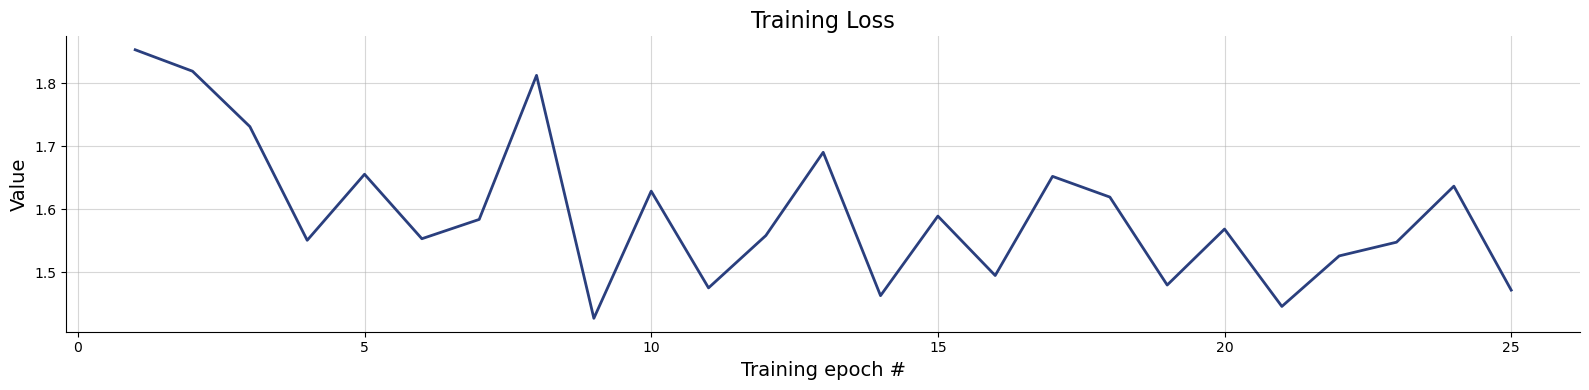

In [22]:
import pandas as pd

f = bf.diagnostics.plots.loss(
    train_losses=pd.DataFrame(history.history['loss'])
)

At this point you should validate the consistency of your trained amortizer and check out the calibration using the SBC technique.

## Inference Phase
Once the approximator has passed all consistency checks, we can now go ahead and apply it to real data!